In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
#from datetime import time, datetime, timedelta
import numpy as np
import pandas as pd
import time
#from sklearn import mixture
import matplotlib.pyplot as plt
#from matplotlib import rcParams
#from pylab import arange,pi,sin,cos,sqrt
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (14, 6)})

# MLE: Maximum Likelihood Estimator

Se trata de un algoritmo de desagregación basado en una extensión del algoritmo de Hart'92. Es un método supervisado de desagregación puesto que es necesario seleccionar ciertos parámetros. 

Cargamos ukdale: 

In [3]:
from nilmtk import DataSet
ukdale = DataSet('data/ukdale.h5')

Seleccionamos el dispositivo *kettle* y los *mains*

In [4]:
elec=ukdale.buildings[1].elec
kettle=elec['kettle']
mains=elec.mains()

### Gráfica de consumo agregado y de la tetera (*kettle*) en un día 

Obtenemos el ventanado:

In [5]:
print "Mains timeframe:"
print mains.get_timeframe()
print "Kettle timeframe:"
print kettle.get_timeframe()

Mains timeframe:
TimeFrame(start='2013-03-17 19:12:43.100000+00:00', end='2015-01-05 06:27:12+00:00', empty=False)
Kettle timeframe:
TimeFrame(start='2012-11-09 22:28:18+00:00', end='2015-01-05 06:16:04+00:00', empty=False)


Seleccionamos un día y aplicamos un nuevo ventanado

Mains timeframe:
TimeFrame(start='2013-03-18 00:00:00+00:00', end='2013-03-19 00:00:00+00:00', empty=False)
Kettle timeframe:
TimeFrame(start='2013-03-18 00:00:00+00:00', end='2013-03-19 00:00:00+00:00', empty=False)


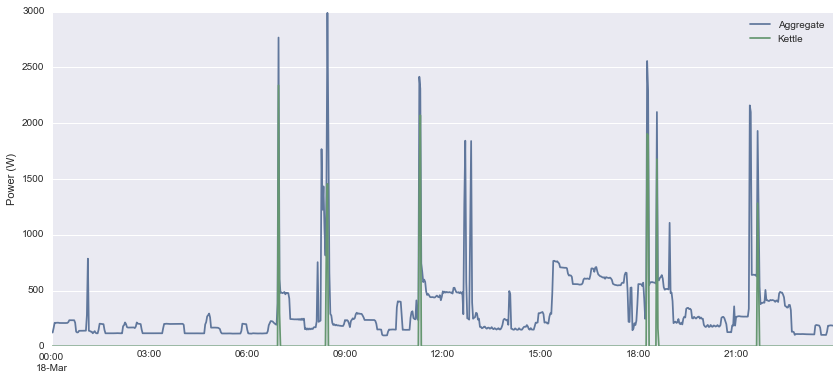

In [7]:
from nilmtk import TimeFrame
kettle.store.window = TimeFrame("2013-03-18  00:00:00+00:00", "2013-03-19  00:00:00+00:00")
mains.store.window = TimeFrame("2013-03-18  00:00:00+00:00", "2013-03-19  00:00:00+00:00")

print "Mains timeframe:"
print mains.get_timeframe()
print "Kettle timeframe:"
print kettle.get_timeframe()

mains.plot()
kettle.plot()
plt.legend(['Aggregate','Kettle'])
plt.ylabel('Power (W)')

Como se puede observar, algunos picos del consumo agregado se deben al uso de la tetera. 

In [8]:
kettle.store.window.clear()
mains.store.window.clear()

## Desagregación de la tetera mediante MLE

Primeramente, nuestro algoritmo tiene que aprender la signatura de la tetera: *onpower, offpower y duración*. 

Entrenamos el modelo con un histórico de un año (aproximadamente) sampleado a 10 segundos por muestra

In [10]:
from nilmtk.disaggregate.maximum_likelihood_estimation import MLE
mle=MLE()
mle.sample_method='median'
mle.sample_period='10s'
mle.thDelta=2000 

# Obteniendo las muestras de training y entrenando el modelo. 
from nilmtk.metergroup import MeterGroup
kettle.store.window.end='2013-11-09 00:00:00+00:00'
mg = MeterGroup(meters=[kettle])

start = time.time()
mle.train(mg)
end = time.time()
print"Runtime = " +str(end-start)+" seconds."

Training on chunk
Samples of onpower: 1356
Samples of offpower: 1356
Samples of duration: 1356
Training onpower
Training offpower
Training duration
Runtime = 22.7788348198 seconds.


### Gráfica de las *signaturas* aprendidas por el modelo contra los datos reales de la tetera. 

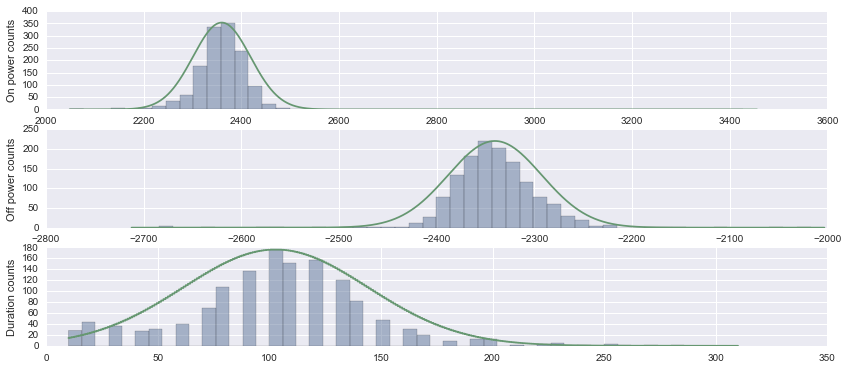

In [11]:
mle.featuresHist()

Se puede obervar como *onpower* y *offpower* tienen una distribución similar que ronda entre los 2200 y 2500 W, lo cual era lo esperado. Sin embargo, la *signatura* de la duración muestra una  mayor variación en su distribución. Esta duración es directamente proporcional a la cantidad de agua que se hierve en la tetera y su variación es completamente debida a un *factor humano de uso*. Por lo tanto, *onpower y offpower* modela el tipo de electrodoméstico y tetera, mientras que la duración modela el uso específico en esa casa. 

### Desagregación

Fijándonos en los histogramas de las *signaturas*, podemos seleccionar manualmente los parámetros de desagregación para nuestro algoritmo supervisado. 

In [12]:
# set disaggregation parameters 
mle.powerNoise = 2200 # Background noise in the main. Potential candidates are above this threshold
mle.powerPair = 200 # Max diff between onpower and offpower
mle.timeWindow = 250 # To avoid high computation
mle.thLikelihood = 1e-10 # Threshold above which events are classed as kettle

En este ejemplo, usaremos un ventanado de 6 meses (aproximadamente) para acelerar el cómputo 

In [13]:
mains.store.window.clear()
mains.store.window.start='2014-06-01 00:00:00+00:00'
mains.get_timeframe()

TimeFrame(start='2014-06-01 00:00:00+00:00', end='2015-01-05 06:27:12+00:00', empty=False)

La desagregación se guarda en otro archivo con extensión h5. A su vez, también se guarda el consumo agregado. 

In [14]:

# disaggregate kettle and save results to file
from nilmtk.datastore import HDFDataStore
disag_store_path = 'data/ukdale_disag.h5'
disag_store = HDFDataStore(disag_store_path, 'w')

start = time.time()
mle.disaggregate(mains, disag_store)
end=time.time()
print "Runtime = " +str(end-start)+" seconds."

Checking units
463 events found.
257 onEvents found
221 onEvents no paired.
1 chunks disaggregated
Runtime = 128.386829853 seconds.


Ahora, si quisieramos abrir el archivo donde hemos realizado la desagregación, volvemos a usar el método DataSet. Comprobamos como sólo tenemos dos *ElecMeter*: el correspondiente al consumo agregado y a la tetera. 

In [15]:
# open disaggregated data file
disag=DataSet(disag_store_path)

# print meters
disag.buildings[1].elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='NILMTK_MLE_2016-04-26T13:01:52', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='NILMTK_MLE_2016-04-26T13:01:52', appliances=[Appliance(type='kettle', instance=1)])
)

### Gráfica del consumo agregado, sub-meter de la tetera y desagregación de la tetera

Vemos como el periodo es el anteriormente desagregado

In [16]:
dsg_elec=disag.buildings[1].elec
dsg_elec.get_timeframe()

TimeFrame(start='2014-06-01 01:00:00+01:00', end='2015-01-05 06:27:12+00:00', empty=False)

Eligimos un ventanado y comprobamos en la siguiente gráfica como se ha llevado a cabo la desagregación. 

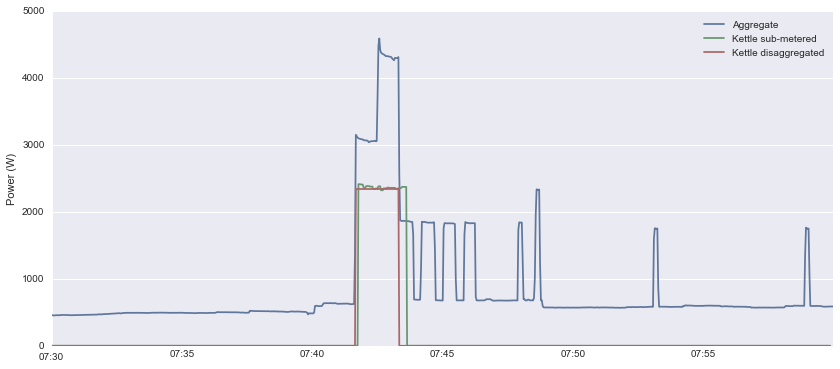

In [17]:
dsg_kettle=dsg_elec['kettle']
timeframe=TimeFrame("2014-12-25  07:30:00+00:00", "2014-12-25  08:00:00+00:00")
dsg_kettle.store.window = timeframe
mains.store.window=timeframe
kettle.store.window=timeframe
mains.plot()
kettle.plot()
dsg_kettle.plot()
plt.legend(['Aggregate','Kettle sub-metered','Kettle disaggregated'])
plt.ylabel('Power (W)')